In [1]:
import torch, torch.nn as nn, re, pandas as pd, numpy as np, seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from scipy import stats

In [16]:
corpora = ['Esperanto.txt', 'Interlingua.txt', 'Lojban.txt', 'Lfn.txt', 'Russian.txt', 'English.txt', 'German.txt', 'Japanese.txt', 'Mandarin.txt', 'Hindi.txt']
natural = ['Russian.txt', 'German.txt', 'English.txt', 'Japanese.txt', 'Mandarin.txt', 'Hindi.txt']
constructed = ['Esperanto.txt', 'Interlingua.txt', 'Lojban.txt', 'Lfn.txt']

Using character frequency distributions

In [17]:
def char_frequency(corpus, sequences=None, n_gram=None):
    with open(corpus) as f:
        if sequences:
            text = f.read().splitlines()[:int(sequences / len(corpora))]
            print(f'{len(text)} lines of text from {corpus[:(len(corpus)-4)]} corpus.')
        else:
            text = f.read().splitlines()
        f.close()
    df = pd.DataFrame(columns=['Char', 'Act_Freq', 'Rel_Freq', 'Zipf_Freq', 'Norm_Freq'])
    if n_gram == 'uni':
        frequencies = Counter(char for line in text for char in line if char.split())
    elif n_gram == 'bi':
        frequencies = Counter(word[i:i+2] for line in text for word in line.split() for i in range(len(word)-1))
    else:
        frequencies = Counter(char for line in text for char in line if char.split())   
    frequencies = frequencies.most_common()
    top_frequency = frequencies[0][1]
    relative_freq_sum = sum([1/i for i in range(1, len(frequencies)+1)])
    for index, item in enumerate(frequencies, start=1):
        relative_freq = 1/index
        zipf_freq = top_frequency * (1/index)
        normalized_freq = relative_freq / relative_freq_sum
        df.loc[index] = [item[0], item[1], relative_freq, zipf_freq, normalized_freq]
    return df


def char_vocabulary(corpus=None, df=None, sequences=None, n_gram=None):
    if corpus:
        df = char_frequency(corpus, sequences=sequences, n_gram=n_gram)
    return {char: freq for char, freq in zip(df['Char'], df['Act_Freq'])}


def plot_char_dist(df, chars=None):
    if chars: df = df.head(chars)
    plt.figure(figsize=(10, 10))
    plt.ylabel('Zipf Frequency')
    plt.xlabel('Char')
    plt.xticks(rotation=90)
    plt.bar(df['Char'], df['Zipf_Freq'])
    plt.show()
    
    
def corpus_lengths(corpora):
    lengths = {}
    for file in corpora:
        with open(file, 'r', encoding='utf-8') as f:
            data = f.read().splitlines()
            f.close()
        lengths[f'{file.split(".")[0]}'] = len(data)
    return lengths


def vocab_sizes(corpora):
    sizes = {}
    for file in corpora:
        vocab = char_vocabulary(corpus=file, df=None, limit=None)
        sizes[f'{file.split(".")[0]}'] = len(vocab)
    return sizes
    
    
def obfuscate_label_text(corpus, vocab, sequences, classification):
    with open(corpus, 'r', encoding='utf-8') as f:
        if sequences:
            text = f.read().splitlines()[:int(sequences / len(corpora))]
        else:
            text = f.read().splitlines()
        f.close()
        # Labeling for binary classification
        if classification == 'binary':
            if corpus in natural:
                label = [0] * len(text)
            elif corpus in constructed:
                label = [1] * len(text)
        # Labeling for multi-classification
        elif classification == 'multi':
            label = [corpora.index(corpus)] * len(text)
        labeled = list(zip(text, label))
        f.close()
    # Char-based frequency mapping of characters in each string    
    mapping = {value: chr(97 + i) for i, value in enumerate(vocab.values())}
    vocab = {k: mapping[v] for k, v in vocab.items()}
    table = str.maketrans(vocab)
    obfuscated = [(line[0].translate(table), line[1]) for line in labeled]
    return obfuscated


# def one_hot_encode(data, vocab):
#     seq_length = max(len(line[0] for line in data))
#     string_encoded = np.zeros((seq_length, len(vocab)), dtype=np.float32)
#     for string, label in data:
#         for i, char in enumerate(string):
#             if i >= seq_length:
#                 break
#             string_encoded[i][vocab[char]] = 1
#         label_encoded = np.array([label], dtype=np.int64)
#     return string_encoded, label_encoded


def preprocess_text(corpora, sequences=None, classification='binary', n_gram=None):
    data = []
    for corpus in corpora:
        df = char_frequency(corpus=corpus, sequences=sequences, n_gram=None)
        vocab = char_vocabulary(df=df)
        data.extend(obfuscate_label_text(corpus=corpus, vocab=vocab, sequences=sequences, classification=classification))
    return data

In [ ]:
df = char_frequency('German.txt', n_gram='bi')
df = df.head(20)
plot_char_dist(df)

In [ ]:
cdf = df['Act_Freq'].cumsum() / df['Act_Freq'].sum()
a = 1.5
null_hypothesis = 'zipf'
zipf_dist = stats.zipf(a, loc=1)
zipf_cdf = zipf_dist.cdf(range(1, len(df) + 1))
test_statistic, p_value = stats.kstest(cdf, zipf_cdf)
print(p_value)

Binary Classification Using SVM

In [ ]:
# Preprocess
data = preprocess_text(corpora, sequences=100000, classification='binary')
text, labels = [d[0] for d in data], [d[1] for d in data]
vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(1,2))
vectorizer.fit(text)
text = vectorizer.transform(text)

# Split 
x_train, x_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
# Model
clf = SGDClassifier(loss="log_loss", tol=1e-3, verbose=0, random_state=42, validation_fraction=0.1)
batch_size = 10000
num_batches = x_train.shape[0] // batch_size

# Training
for i in range(num_batches):
    start = i * batch_size
    end = min((i + 1) * batch_size, x_train.shape[0])
    batch_x, batch_y = x_train[start:end], y_train[start:end]
    clf.fit(batch_x, batch_y)

In [ ]:
# Plot
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
# Metrics
accuracy = clf.score(x_test, y_test)
print(f'Accuracy: {accuracy}')

Multi-Classification Using SVM

In [11]:
# Preprocess
data = preprocess_text(corpora, sequences=100000, classification='multi')
text, labels = [d[0] for d in data], [d[1] for d in data]
vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(2,2))
vectorizer.fit(text)
text = vectorizer.transform(text)

# Split 
x_train, x_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42, shuffle=True)

12500 lines of text from Esperanto corpus.
12500 lines of text from Interlingua corpus.
12500 lines of text from Lojban corpus.
12500 lines of text from Lfn corpus.
12500 lines of text from Russian corpus.
12500 lines of text from English corpus.
12500 lines of text from German corpus.
12500 lines of text from Hindi corpus.


In [12]:
# Model
clf = SGDClassifier(loss="log_loss", tol=1e-3, verbose=0, random_state=42, validation_fraction=0.1)
batch_size = 10000
num_batches = x_train.shape[0] // batch_size

# Training
for i in range(num_batches):
    start = i * batch_size
    end = min((i + 1) * batch_size, x_train.shape[0])
    batch_x, batch_y = x_train[start:end], y_train[start:end]
    clf.fit(batch_x, batch_y)

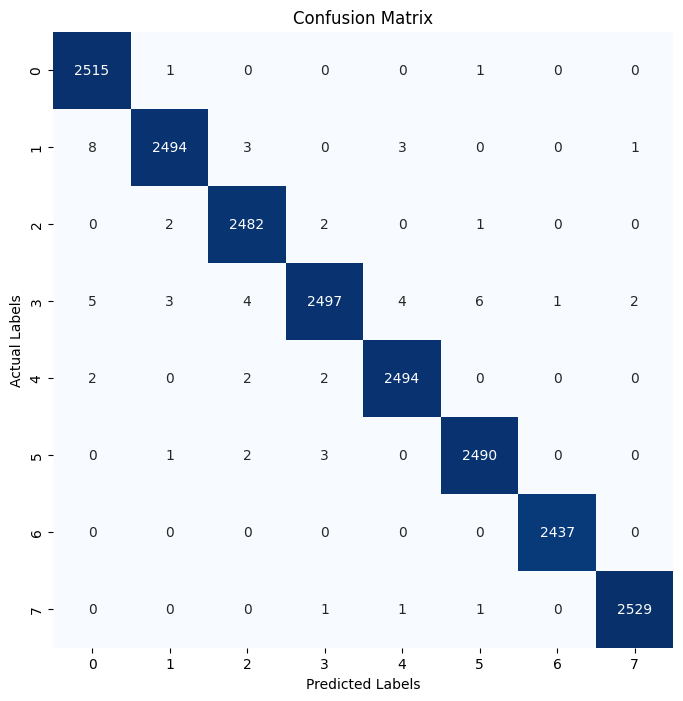

In [13]:
# Plot
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')
ax.set_title('Confusion Matrix')
plt.show()

In [14]:
# Metrics
accuracy = clf.score(x_test, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9969


Multi-Classification Using RNN

In [ ]:
# Preprocess
data = preprocess_text(corpora, sequences=200000, classification='multi')
text, labels = [d[0] for d in data], [d[1] for d in data]
vectorizer = CountVectorizer(analyzer='char')
vectorizer.fit(text)
text = vectorizer.transform(text)

# Split 
x_train, x_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42, shuffle=True)

In [18]:
avgs = []
for corpus in corpora:
    with open(corpus, 'r', encoding='utf-8') as f:
        text = f.read().splitlines()
        f.close()
    longest = len(max(text))
    avg = sum(map(len, text)) / len(text)
    avgs.append(avg)
    print(f'{corpus}: Longest sequence is {longest} char, average is {int(avg)} char.')
    
print(f'Avg length is {int(sum(avgs) / len(avgs))}')

Esperanto.txt: Longest sequence is 110 char, average is 91 char.
Interlingua.txt: Longest sequence is 73 char, average is 141 char.
Lojban.txt: Longest sequence is 390 char, average is 45 char.
Lfn.txt: Longest sequence is 74 char, average is 111 char.
Russian.txt: Longest sequence is 73 char, average is 98 char.
English.txt: Longest sequence is 223 char, average is 111 char.
German.txt: Longest sequence is 81 char, average is 104 char.
Japanese.txt: Longest sequence is 37 char, average is 45 char.
Mandarin.txt: Longest sequence is 15 char, average is 31 char.
Hindi.txt: Longest sequence is 156 char, average is 85 char.
Avg length is 86


In [ ]:
# Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    
n_hidden = 128
n_categories = len(corpora)
rnn = RNN()

Classification Using CNNs